In [1]:
import pandas as pd
from datetime import date
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
df_global = pd.read_parquet('/Users/manu/Desktop/SUP/Projet 2/AI_model_urban_mobility/data/df_final_15min_NoNan_20250505.parquet')

In [3]:
df_prediction_taux_occupation = pd.read_csv('/Users/manu/Desktop/SUP/Projet 2/AI_model_urban_mobility/data/donnees_predictions/taux_occupation_predictions.csv')

In [4]:
len(df_prediction_taux_occupation)

431424

In [5]:
df_prediction_taux_occupation.columns

Index(['heure_arrondie', 'nom_du_troncon', 'taux_occupation_reel',
       'taux_occupation_pred'],
      dtype='object')

In [6]:
df_global['heure_arrondie'] = pd.to_datetime(df_global['heure_arrondie'])
df_prediction_taux_occupation['heure_arrondie'] = pd.to_datetime(df_prediction_taux_occupation['heure_arrondie'])
cutoff_date = pd.to_datetime('2025-03-08')

train_df = df_global[df_global['heure_arrondie'] < cutoff_date].copy()

In [7]:
train_df['code_couleur'] = train_df['code_couleur'].astype('int')

In [8]:
test_df = pd.merge(
    df_prediction_taux_occupation,
    df_global,
    on=['heure_arrondie', 'nom_du_troncon']
)

In [9]:
# Selection des variables explicatives
feature_cols_train = ['taux_occupation', 'weekday', 'hour', 'minute','is_vacances', 'is_ferie', 'has_event_near_troncon', 'troncon_enc', 'temperature_2m', 'precipitation', 'visibility','wind_speed_10m']
feature_cols_test = ['taux_occupation_pred', 'weekday', 'hour', 'minute','is_vacances', 'is_ferie', 'has_event_near_troncon', 'troncon_enc', 'temperature_2m', 'precipitation', 'visibility','wind_speed_10m']
target_col = 'code_couleur'

In [10]:
X_train = train_df[feature_cols_train]
X_test = test_df[feature_cols_test]
y_train = train_df['code_couleur']

In [11]:
X_test.rename(columns = {'taux_occupation_pred' : 'taux_occupation'}, inplace=True)

<ipython-input-11-1835cdae1e2d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.rename(columns = {'taux_occupation_pred' : 'taux_occupation'}, inplace=True)


In [12]:
# --- Entraînement du modèle ---
print("Entraînement du modèle")
model = RandomForestClassifier(
    n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1
)
model.fit(X_train, y_train)
print("Modèle entraîné.")

Entraînement du modèle
Modèle entraîné.


In [13]:
y_pred = model.predict(X_test)
X_test['code_couleur_predit'] = y_pred

<ipython-input-13-f4e787ce60d4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['code_couleur_predit'] = y_pred


In [14]:
y_true = test_df['code_couleur']


--- Rapport de Classification ---
Analyse de la performance pour chaque code couleur :
              precision    recall  f1-score   support

         3.0       0.99      0.99      0.99    422099
         4.0       0.18      0.18      0.18      4501
         5.0       0.16      0.13      0.14      2139
         6.0       0.37      0.16      0.22      2685

    accuracy                           0.97    431424
   macro avg       0.42      0.36      0.38    431424
weighted avg       0.97      0.97      0.97    431424


--- Matrice de Confusion ---
Visualisation des erreurs de classification :


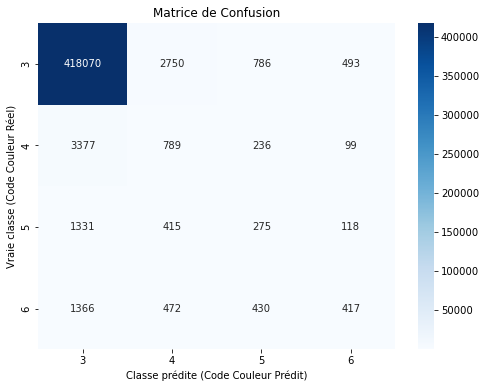

In [15]:
# Générer et afficher le Rapport de Classification
print("\n--- Rapport de Classification ---")
print("Analyse de la performance pour chaque code couleur :")
print(classification_report(y_true, y_pred))


# Matrice de confusion
print("\n--- Matrice de Confusion ---")
print("Visualisation des erreurs de classification :")

labels = sorted(y_true.astype(int).unique())

cm = confusion_matrix(y_true, y_pred, labels=labels)

# Affichage 
plt.figure(figsize=(8, 6)) 
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.title('Matrice de Confusion')
plt.ylabel('Vraie classe (Code Couleur Réel)')
plt.xlabel('Classe prédite (Code Couleur Prédit)')
plt.show()